In [288]:
# add more fc layers for 5 digit output
# train.py
# inference.py

In [289]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import os
from pathlib import Path

import torchvision
from torchvision import datasets

# import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import ttach as tta

import albumentations as A
import albumentations.pytorch

import models
import config

In [290]:
start = time.time()

In [291]:
# setting seed
torch.manual_seed(0)
np.random.seed(0)

In [292]:
# setting device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [293]:
# HYPERPARAMS HERE

# params
lr = 0.005 # was 3e-3
momentum = 0.9 # was 0.9
weight_decay = 3e-3

# lr scheduler
step_size = 5 # after this many epochs we will mult our lr by gamma
gamma = 0.1 # lr multiplier every step_size epochs

# transforms
presize = 224
crop = 224

# batch size
batch_size = 32

# n_epochs
frozen = 2
unfrozen = 5

# tta
tta_crop = int(presize*0.9)

In [294]:
# transforms
train_transform = A.Compose([
        # A.LongestMaxSize(presize),
        A.RandomSizedBBoxSafeCrop(presize, presize),
        # A.PadIfNeeded(presize, presize, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
        # A.SmallestMaxSize(presize),
        # A.RandomCrop(crop, crop),
        A.Normalize(),
        A.Rotate(limit=20),
        A.HorizontalFlip(),
        # A.Cutout(),
        albumentations.pytorch.ToTensorV2()], 
        bbox_params=A.BboxParams(format='albumentations', min_area=256, min_visibility=0.1))

valid_transform = A.Compose([
        # A.LongestMaxSize(presize),
        A.RandomSizedBBoxSafeCrop(presize, presize),
        # A.PadIfNeeded(presize, presize, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
        # A.SmallestMaxSize(presize),
        A.Normalize(),
        albumentations.pytorch.ToTensorV2()],
        bbox_params=A.BboxParams(format='albumentations', min_area=256, min_visibility=0.1))

test_transform = A.Compose([
        # A.LongestMaxSize(presize),
        A.RandomSizedBBoxSafeCrop(presize, presize),
        # A.PadIfNeeded(presize, presize, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
        # A.SmallestMaxSize(presize),
        A.Normalize(),
        albumentations.pytorch.ToTensorV2()],
        bbox_params=A.BboxParams(format='albumentations', min_area=256, min_visibility=0.1))

In [295]:
# dataset class
class dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return (self.df.shape[0])

    def __getitem__(self, index):
        image = cv2.imread(self.df.fname[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        class_id = self.df.label[index]

        xmin = self.df.xmin_alb[index]
        ymin = self.df.ymin_alb[index]
        xmax = self.df.xmax_alb[index]
        ymax = self.df.ymax_alb[index]

        bboxes = [[xmin, ymin, xmax, ymax, class_id]]

        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes)
            
            image = transformed['image']
            bboxes = transformed['bboxes']
            
        label = torch.tensor(bboxes).flatten()
        
        return image, label

In [297]:
# just to check if everything works we only use the sample of all data
frac = 0.3
# df = pd.read_csv(config.DF_PATH, usecols=['fname', 'height', 'width',
#                                           'xmin_alb', 'ymin_alb', 'xmax_alb', 'ymax_alb',
#                                           'label', 'kfold'])

df = pd.read_csv(config.DF_PATH, usecols=['fname',
                                          'xmin_alb', 'ymin_alb', 'xmax_alb', 'ymax_alb',
                                          'label', 'kfold']).sample(frac=frac).reset_index(drop=True)
df.shape

(1016, 7)

In [298]:
# # checking for "out of proportion" pictures - too tall, or too wide, that are hard to transform and train
# df['ratio'] = np.maximum(df.height, df.width) / np.minimum(df.height, df.width)
# df.ratio.sort_values(ascending=False)

In [299]:
# create dfs
train_df = df[df.kfold.isin([0,1,2])].reset_index(drop=True)
valid_df = df[df.kfold==3].reset_index(drop=True)
test_df = df[df.kfold==4].reset_index(drop=True) # could be a problem with 4th fold

# create dataset
train_dataset = dataset(train_df, train_transform)
valid_dataset = dataset(valid_df, valid_transform)
test_dataset = dataset(test_df, test_transform)

# create loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

In [300]:
# just a check if all is good with the shapes of the loaders
# print(f'dataloader test: {next(iter(train_loader))[0].shape}')
print(f'dataloader test: {next(iter(train_loader))[0].shape}, {next(iter(valid_loader))[0].shape}')

dataloader test: torch.Size([32, 3, 224, 224]), torch.Size([32, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


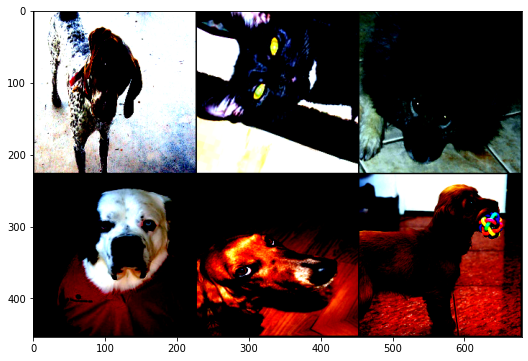

In [301]:
# displayig the data (looks this way because of normalization)
batch_tensor = next(iter(train_loader))[0][:6,...]
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=3)

# grid_img.shape
plt.figure(figsize=(16,6))
plt.imshow(grid_img.permute(1, 2, 0));

In [302]:
model = models.resnet18(5).to(device) # good
# model = models.resnext50_32x4d(5).to(device) # 
# model = models.wide_resnet50_2(5).to(device) # 
# model = models.vgg(5).to(device) # good

# loss
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, mode='min')

In [303]:
def train_model(n_epochs=1,
                model=model,
                train_loader=train_loader,
                valid_loader=valid_loader,
                criterion=criterion,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler):
    
    total_time = time.time()
    print(f'================')
    print(f'started training...')
    print(f'================')

    for epoch in range(n_epochs):
        
        model.train()

        t0 = time.time()

        correct_on_epoch = 0 # train acc
        total_num_images = 0 # train acc
        epoch_loss = 0
        

        for batch, (images, labels) in enumerate(train_loader):
            
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            total_num_images += labels.size(0) # train acc

            optimizer.zero_grad()
            outputs = model(images.float())
            
            preds = outputs[:,-1].round() # train acc
            
            # loss = criterion(outputs.float(), labels.float())
            loss = criterion(labels.float(), outputs.float())
            
            epoch_loss += loss

            correct_on_batch = (preds==labels[:,-1]).sum().item() # train acc
            
            correct_on_epoch += correct_on_batch # train acc

            loss.backward()
            optimizer.step()
        
        # train acc/loss
        train_epoch_acc = round((correct_on_epoch/total_num_images), 4) # train acc
        train_avg_epoch_loss = round(float(epoch_loss/len(train_loader)), 4)
        # valid acc/loss
        valid_avg_epoch_loss, valid_epoch_accuracy, mean_iou = test_model(model, valid_loader)
        # valid iou
        

        # lr_scheduler.step()
        epoch_time = round(time.time() - t0)
        # for reduce on plateau LR
        lr_scheduler.step(valid_avg_epoch_loss)
        
        print(f'epoch: [{epoch+1}/{n_epochs}] | train loss: {train_avg_epoch_loss} | train acc: {train_epoch_acc} | valid loss: {valid_avg_epoch_loss} | valid acc: {valid_epoch_accuracy} | iou: {mean_iou} | time: {epoch_time//60:.0f}m {epoch_time%60:.0f}s')
    
    return model

In [304]:
def test_model(model, test_loader):
    
    model.eval()
    
    correct_on_epoch = 0
    total_num_images = 0
    epoch_loss = 0
    epoch_iou = []

    all_batch_acc = []
    
    with torch.no_grad():
        
        for batch, (images, labels) in enumerate(test_loader):
            
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            true_bb = labels[:,:-1]
                        
            total_num_images += images.size(0)

            outputs = model(images)
            preds = outputs[:,-1].round()
            pred_bb = outputs[:,:-1]
            
            loss = criterion(outputs, labels)
            epoch_loss += loss

            correct_on_epoch += (preds==labels[:,-1]).sum().item()
    
            # batch iou
            batch_iou = iou(true_bb, pred_bb)
            epoch_iou.append(batch_iou)

            # print(f'batch {batch+1} iou: {batch_iou}')

    test_epoch_accuracy = round((correct_on_epoch/total_num_images), 4)
    test_avg_epoch_loss = round(float(epoch_loss/len(test_loader)), 4)
    mean_iou = np.round(np.mean(epoch_iou), 4)
    
    return test_avg_epoch_loss, test_epoch_accuracy, mean_iou

In [305]:
def iou(true_bb, pred_bb):

    batch_iou = []

    for idx, (true, pred) in enumerate(zip(true_bb, pred_bb)):

        pred = torch.clip(pred, min=0.0, max=1.0).to('cpu')
        true = torch.clip(true, min=0.0, max=1.0).to('cpu')

        xmin_t, ymin_t, xmax_t, ymax_t = true
        xmin_p, ymin_p, xmax_p, ymax_p = pred

        xmin_intersect = np.maximum(xmin_t, xmin_p)
        ymin_intersect = np.maximum(ymin_t, ymin_p)
        xmax_intersect = np.minimum(xmax_t, xmax_p)
        ymax_intersect = np.minimum(ymax_t, ymax_p)

        if xmin_intersect < xmax_intersect and ymin_intersect < ymax_intersect:

            intersection_area = (xmax_intersect - xmin_intersect) * (ymax_intersect - ymin_intersect)
            union_area = (xmax_t-xmin_t)*(ymax_t-ymin_t)+(xmax_p-xmin_p)*(ymax_p-ymin_p)-intersection_area + 1e-6

            assert intersection_area > 0, 'intersection area cat be < 0'
            assert union_area > 0, 'union area cant be < 0'

            iou = intersection_area / union_area
            batch_iou.append(iou)

        else:
            batch_iou.append(0.0)

    return np.round(np.mean(batch_iou), 4)

# tests
# 1 in 2 vertical
bb_1 = torch.tensor([[0, 0, 0.5, 0.5], [0, 0, 0.5, 0.5]])
bb_2 = torch.tensor([[0, 0, 0.5, 1], [0, 0, 0.5, 1]])
# 2 in 1 vertical
bb_3 = torch.tensor([[0, 0, 0.5, 1], [0, 0, 0.5, 1]])
bb_4 = torch.tensor([[0, 0, 0.5, 0.5], [0, 0, 0.5, 0.5]])
# 1 inside 2 horizontal
bb_5 = torch.tensor([[0, 0, 0.5, 0.5], [0, 0, 0.5, 0.5]])
bb_6 = torch.tensor([[0, 0, 1, 0.5], [0, 0, 1, 0.5]])
# 2 inside 1 horizontal
bb_7 = torch.tensor([[0, 0, 1, 0.5], [0, 0, 1, 0.5]])
bb_8 = torch.tensor([[0, 0, 0.5, 0.5], [0, 0, 0.5, 0.5]])
# no itersection
bb_9 = torch.tensor([[0, 0, 0.5, 0.5], [0, 0, 0.5, 0.5]])
bb_10 = torch.tensor([[0.5, 0, 1, 0.5], [0.5, 0, 1, 0.5]])

# test
assert iou(bb_1, bb_2) == 0.5
assert iou(bb_3, bb_4) == 0.5
assert iou(bb_5, bb_6) == 0.5
assert iou(bb_7, bb_8) == 0.5
assert iou(bb_9, bb_10) == 0


In [306]:
# unfreeze all the params for training
def unfreeze(model=model):
    for param in model.parameters():
        param.requires_grad = True
    return model

In [307]:
%%time

train_model(frozen)
unfreeze()
train_model(unfrozen)
print('Training done.')

started training...
epoch: [1/2] | train loss: 0.1998 | train acc: 0.6236 | valid loss: 0.1473 | valid acc: 0.6977 | iou: 0.2318 | time: 0m 48s
epoch: [2/2] | train loss: 0.1016 | train acc: 0.7561 | valid loss: 0.1018 | valid acc: 0.7907 | iou: 0.3183 | time: 0m 54s
started training...
epoch: [1/5] | train loss: 0.0854 | train acc: 0.7578 | valid loss: 0.0816 | valid acc: 0.8279 | iou: 0.3756 | time: 2m 1s
epoch: [2/5] | train loss: 0.0744 | train acc: 0.7823 | valid loss: 0.0663 | valid acc: 0.8605 | iou: 0.4095 | time: 1m 58s
epoch: [3/5] | train loss: 0.0681 | train acc: 0.8036 | valid loss: 0.0568 | valid acc: 0.9349 | iou: 0.429 | time: 1m 51s
epoch: [4/5] | train loss: 0.0606 | train acc: 0.8052 | valid loss: 0.0401 | valid acc: 0.9767 | iou: 0.4492 | time: 2m 1s
epoch: [5/5] | train loss: 0.0564 | train acc: 0.82 | valid loss: 0.0435 | valid acc: 0.9953 | iou: 0.4581 | time: 2m 19s
Training done.
Wall time: 11min 52s


In [308]:
# lr=0.005, momentum=0.9, SGD, RandomSizedBBoxSafeCrop, frac=0.3
# epoch: [3/3] | train loss: 0.0656 | train acc: 0.7725 | valid loss: 0.0524 | valid acc: 0.9209 | iou: 0.4249 | time: 1m 51s

In [309]:
checkpoint = {'model': model,
              'state_dict': model.state_dict()}

torch.save(checkpoint, config.MODEL_OUTPUT)

In [310]:
%%time
# testing with train data
_, train_acc, train_iou = test_model(model, train_loader)
print(f'train acc: {train_acc} | train iou: {train_iou}')

train acc: 0.9935 | train iou: 0.5328
Wall time: 50.5 s


In [311]:
%%time
# testing with test data
_, test_acc, test_iou = test_model(model, test_loader)
print(f'test acc: {test_acc} | test iou: {test_iou}')

test acc: 0.9789 | test iou: 0.4645
Wall time: 15.7 s


In [312]:
# %%time
# # tta with test data
# tta_crop = int(presize*0.9)
# tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.five_crop_transform(tta_crop, tta_crop))

# tta_transforms = A.Compose([
#     A.SmallestMaxSize(presize),
#     A.Normalize(),
#     albumentations.pytorch.ToTensorV2()
# ])

# tta_dataset = dataset(valid_df, transform=tta_transforms)
# tta_loader = DataLoader(tta_dataset, batch_size=1, shuffle=False) # num_workers=0 on cpu

# _, tta_acc, tta_iou = test_model(tta_model, tta_loader)

# print(f'TTA acc: {tta_acc} | tta iou: {tta_iou}')

In [313]:
total_time = time.time() - start
print(f'Total time: {total_time//60:.0f}m {total_time%60:.0f}s')

Total time: 13m 1s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


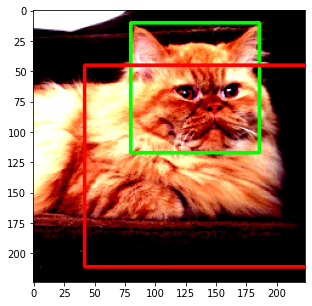

In [314]:
with torch.no_grad():
    # visualize predictions of the model
    # take a random picture from a dataset
    idx = np.random.randint(len(train_dataset))
    image, label = train_dataset[idx]
    # predict new bbox
    image = torch.unsqueeze(image, 0)
    outputs = model(image)
    outputs = outputs.flatten()
    # print(f'outputs shape: {outputs}')
    pred_bb = np.round(outputs[:-1], 4).tolist() # <---- pred bb
    # print(f'pred bb shape: {pred_bb}')
    pred_start = (int(pred_bb[0]*crop), int(pred_bb[1]*crop))
    pred_end = (int(pred_bb[2]*crop), int(pred_bb[3]*crop))
    pred_id = outputs[-1].long().item()
    # need to permute tensor for visualization
    image = torch.squeeze(image, 0)
    image = np.array(image.permute(1, 2, 0))
    # bbox = first 4 digits
    bbox = np.round(label[:-1], 4).tolist() # <---- true bb
    # class = last digit
    class_id = label[-1].long().item()
    # define 2 points for rectangle
    start_point = (int(bbox[0]*crop), int(bbox[1]*crop))
    end_point = (int(bbox[2]*crop), int(bbox[3]*crop))
    # define a color and thickness
    color = (0, 255, 0)
    color2 = (255, 0, 0)
    
    thickness = 2

    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    image = cv2.rectangle(image, pred_start, pred_end, color2, thickness)

    # cv2.imshow('image', image)

    plt.figure(figsize=(5, 5))
    plt.imshow(np.array(image));